In [37]:
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, Linear, global_mean_pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [38]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [39]:
train_dataset, test_dataset = train_test_split(hom_dataset, test_size=0.2)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [40]:
class HomoGNN(torch.nn.Module):
    def __init__(self,
                 hidden_channels,
                 out_channels,
                 num_layers=2,
                 conv=SAGEConv, # Can use any kind of graph conv since bipartite message passing isn't used here
                 act=F.relu,
                 aggr='mean'):
        
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(conv((-1, -1), hidden_channels, aggr=aggr))

        self.classifier = Linear(hidden_channels, out_channels)
        self.act = act

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.act(x)
        
        pooled = global_mean_pool(x, batch)
        out = self.classifier(pooled)
        return out

In [45]:
model = HomoGNN(32, 32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
model.convs[0]

SAGEConv((-1, -1), 32, aggr=mean)

In [46]:
def train(model, loader, optimizer, criterion, device="cpu"):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in loader:
        batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(logits, batch.y)
        
        preds = logits.argmax(dim=1).detach().cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(batch.y.cpu().numpy())
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.y.size(0)

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, accuracy, f1

def test(model, loader, criterion, device="cpu"):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(logits, batch.y)
            
            preds = logits.argmax(dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(batch.y.cpu().numpy())
            total_loss += loss.item() * batch.y.size(0)

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, accuracy, f1

In [47]:
# Initialize tracking
metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
    'train_f1': [],
    'test_f1': []
}

best_val_loss = float('inf')
epochs = 15

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_f1 = test(model, test_loader, criterion)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['test_loss'].append(test_loss)
    metrics['train_acc'].append(train_acc)
    metrics['test_acc'].append(test_acc)
    metrics['train_f1'].append(train_f1)
    metrics['test_f1'].append(test_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Test F1: {test_f1:.4f}\n")

Epoch 1/15
Train Loss: 3.0104 | Test Loss: 2.1781
Train Acc: 0.1437 | Test Acc: 0.1000
Train F1: 0.0542 | Test F1: 0.0305

Epoch 2/15
Train Loss: 1.8865 | Test Loss: 1.8291
Train Acc: 0.1792 | Test Acc: 0.1500
Train F1: 0.0942 | Test F1: 0.1032

Epoch 3/15
Train Loss: 1.7985 | Test Loss: 1.7923
Train Acc: 0.1604 | Test Acc: 0.1917
Train F1: 0.1436 | Test F1: 0.1437

Epoch 4/15
Train Loss: 1.7870 | Test Loss: 1.7942
Train Acc: 0.1729 | Test Acc: 0.2417
Train F1: 0.1469 | Test F1: 0.1161

Epoch 5/15
Train Loss: 1.7852 | Test Loss: 1.7911
Train Acc: 0.1708 | Test Acc: 0.1417
Train F1: 0.1577 | Test F1: 0.0907

Epoch 6/15
Train Loss: 1.7895 | Test Loss: 1.8076
Train Acc: 0.1771 | Test Acc: 0.1167
Train F1: 0.1329 | Test F1: 0.0749

Epoch 7/15
Train Loss: 1.7726 | Test Loss: 1.8078
Train Acc: 0.1688 | Test Acc: 0.1250
Train F1: 0.1490 | Test F1: 0.0812

Epoch 8/15
Train Loss: 1.7663 | Test Loss: 1.7965
Train Acc: 0.2062 | Test Acc: 0.1833
Train F1: 0.1776 | Test F1: 0.1213

Epoch 9/15
Train

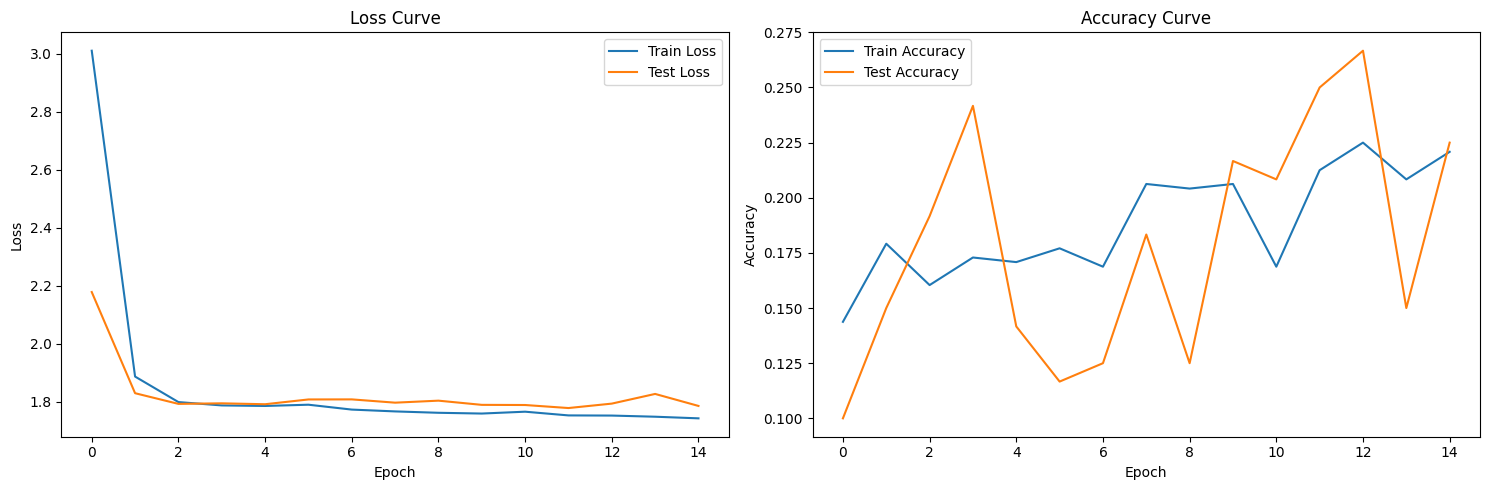

,Epoch,Train Loss,Test Loss,Train Acc,Test Acc,Train F1,Test F1
0,1,3.0104,2.1781,0.1437,0.1000,0.0542,0.0305
1,2,1.8865,1.8291,0.1792,0.1500,0.0942,0.1032
2,3,1.7985,1.7923,0.1604,0.1917,0.1436,0.1437
3,4,1.7870,1.7942,0.1729,0.2417,0.1469,0.1161
4,5,1.7852,1.7911,0.1708,0.1417,0.1577,0.0907
5,6,1.7895,1.8076,0.1771,0.1167,0.1329,0.0749
6,7,1.7726,1.8078,0.1688,0.1250,0.1490,0.0812
7,8,1.7663,1.7965,0.2062,0.1833,0.1776,0.1213
8,9,1.7616,1.8034,0.2042,0.1250,0.1622,0.1014
9,10,1.7590,1.7889,0.2062,0.2167,0.1669,0.1498


In [48]:
def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['test_loss'], label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def create_metrics_table(metrics):
    df = pd.DataFrame({
        'Epoch': range(1, len(metrics['train_loss'])+1),
        'Train Loss': metrics['train_loss'],
        'Test Loss': metrics['test_loss'],
        'Train Acc': metrics['train_acc'],
        'Test Acc': metrics['test_acc'],
        'Train F1': metrics['train_f1'],
        'Test F1': metrics['test_f1']
    })
    return df.style.format({
        'Train Loss': '{:.4f}',
        'Test Loss': '{:.4f}',
        'Train Acc': '{:.4f}',
        'Test Acc': '{:.4f}',
        'Train F1': '{:.4f}',
        'Test F1': '{:.4f}'
    }).background_gradient(cmap='Blues')

# After training
plot_metrics(metrics)
display(create_metrics_table(metrics))